# Strava Data Exploration and Processing

These are my attempts to make some useful plots with my own Strava data. 

The objectives of this exercise are:
1) Process the raw data into a neater, more useable dataset.
2) Plot calendars (inspired by the [strava_py package](https://github.com/marcusvolz/strava_py) I found on GitHub to show the longer term trend of my activity. I also want to add two colour schemes on the same calendar, to compare the trends in my running and cycling. 
3) Plot overlayed routes, producing a personalised heatmap, much like the one in the paid version of Strava and the ones in [strava_py](https://github.com/marcusvolz/strava_py) and [other blogs](https://knanne.github.io/notebooks/visualize_strava_data_in_python.html).
4) Learn how to use APIs

Objective 1:

Explore the data in the 'activities.csv' download file.

Steps:
- Transform units and calculate new metrics
- Plot scatter

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

df = pd.read_csv('activities.csv')

First look at the 'Activities' file brings up the following issues:
- Many unused/empty metrics.
- Useful metrics (e.g. average pace/speed) are missing for many activities.
- Date and time of each activity in same column.
- 'Elapsed Time' and 'Moving Time'.

Next steps are:
- Produce a new dataframe containing only useful metrics (in this case...).
- Convert the activity times from seconds into minutes and hours.
- Create new columns for the date and start time as separate variables.
- Create new columns with the calculated speed and pace for every activity.
- Make a simple scater plot containing all activities.

In [13]:
cols = ["Activity Date","Activity Name",
        "Activity Type","Activity Description","Elapsed Time",  
        "Distance","Moving Time","Elevation Gain"]      #"Filename","Activity ID",
df = df[cols]

# CONVERT ELAPSED TIME AND MOVING TIME TO MINUTES and HOURS
seconds = df['Moving Time']
df['Moving Time'] = pd.to_timedelta(df['Moving Time'],unit='S')
df['Elapsed Time'] = pd.to_timedelta(df['Elapsed Time'],unit='S')
df['Stationary Time'] = df['Elapsed Time']-df['Moving Time']

# CONVERT TIMES TO MINS AND HRS for plotting
df['Minutes'] = round(seconds/60,2)
df['Hours'] = round(df['Minutes']/60,2)

#CALCULATE PACE SPEED
df['Pace'] = (df['Moving Time']/df['Distance']).dt.round('S')
df['Speed'] = round(df['Distance']*3600/seconds,2)
#seconds = df['Moving Time'].total_seconds()     #TOTAL_SECONDS not working

#SEPARATE DATE AND TIME
df['Activity Date'] = pd.to_datetime(df['Activity Date'])
df['Start Time'] = df['Activity Date'].dt.time
df['Activity Date Only'] = df['Activity Date'].dt.date
df['Day of Week'] = df['Activity Date'].dt.day_name()
#df.head(233)

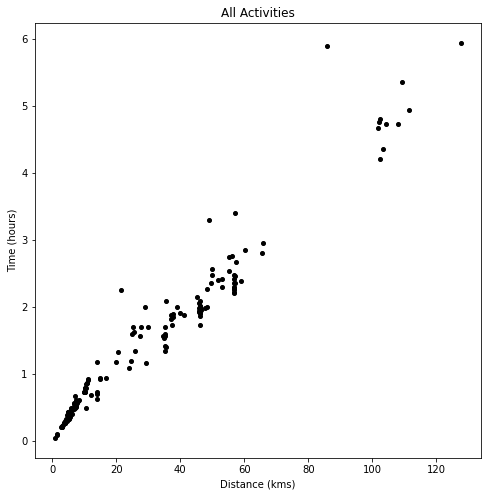

In [14]:
fig, ax = plt.subplots()

ax.plot(df['Distance'],df['Hours'],'ko',markersize=4)     #,label='Activities_Moving'
#ax.plot(distance_kms,times_minutes,'bo',markersize=4,alpha=0.1,label='Activities_Elapsed')

ax.set_title('All Activities')
ax.set_xlabel('Distance (kms)')
ax.set_ylabel('Time (hours)')
plt.gcf().set_size_inches(8,8)

Issues with scatter:

- Lots of activities are the same time and distance so are overlayed in the scatter.
- Runs and rides in same scatter distorts scale.

Solutions:

- Create separate dataframes for running and riding.
- Use Alpha property to disinguish frequency.
- Plot histograms.

In [15]:
runs = df.loc[df["Activity Type"] == 'Run']
rides = df.loc[df["Activity Type"] == 'Ride']

df.to_csv("activities_neat.csv")
runs.to_csv("runs.csv")
rides.to_csv("rides.csv")

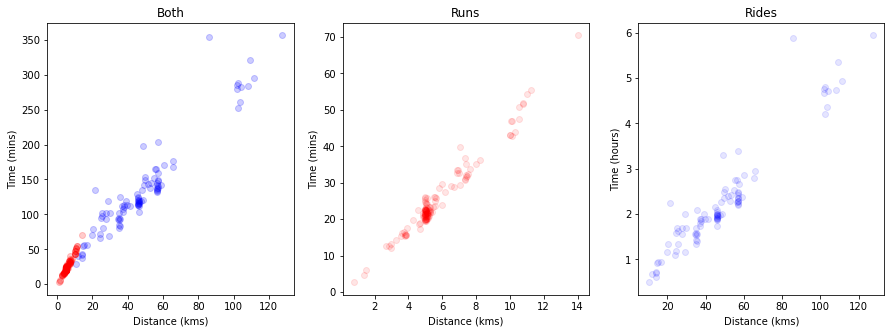

In [16]:
fig, all_fig = plt.subplots(1,3)

all_fig[0].plot(rides['Distance'],rides['Minutes'],'bo',alpha=0.2,label='Rides')
all_fig[0].plot(runs['Distance'],runs['Minutes'],'ro',alpha=0.2,label='Runs')
all_fig[0].set_title('Both')
all_fig[0].set_xlabel('Distance (kms)')
all_fig[0].set_ylabel('Time (mins)')
#all_fig[0].plt.legend()
# NEED TO ADD LEGEND

all_fig[1].plot(runs['Distance'],runs['Minutes'],'ro',alpha=0.1)
all_fig[1].set_title('Runs')
all_fig[1].set_xlabel('Distance (kms)')
all_fig[1].set_ylabel('Time (mins)')

all_fig[2].plot(rides['Distance'],rides['Hours'],'bo',alpha=0.1)
all_fig[2].set_title('Rides')
all_fig[2].set_xlabel('Distance (kms)')
all_fig[2].set_ylabel('Time (hours)')

plt.gcf().set_size_inches(15,5)

In [17]:
print('Runs Distance',
    min(runs['Distance']),max(runs['Distance']))
print('Runs Moving Time',
    min(runs['Moving Time']),max(runs['Moving Time']))
print('Runs Pace',
    min(runs['Pace']),max(runs['Pace']))

print('Rides Distance',
    min(rides['Distance']),max(rides['Distance']))
print('Rides Moving Time',
    min(rides['Moving Time']),max(rides['Moving Time']))
print('Rides Speed',
    min(rides['Speed']),max(rides['Speed']))

run_dist_bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
run_time_bins=[0,10,20,30,40,50,60,70,80]
run_pace_bins=[3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6]
run_ylimits=[0,85]

ride_dist_bins=[10,20,30,40,50,60,70,80,90,100,110,120,130]
ride_time_bins=[0,30,60,90,120,150,180,210,240,270,300,330,360]
ride_speed_bins=[5,10,15,20,25,30]
ride_ylimits=[0,65]

Runs Distance 0.78 14.01
Runs Moving Time 0 days 00:02:37 0 days 01:10:28
Runs Pace 0 days 00:03:20 0 days 00:05:38
Rides Distance 10.62 127.64
Rides Moving Time 0 days 00:29:25 0 days 05:56:19
Rides Speed 9.49 26.62


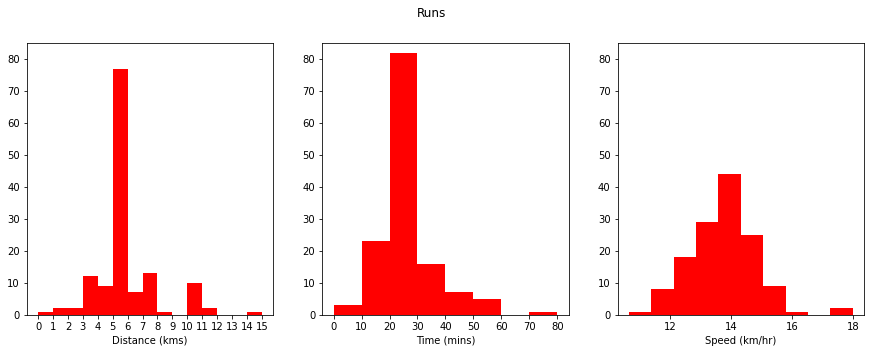

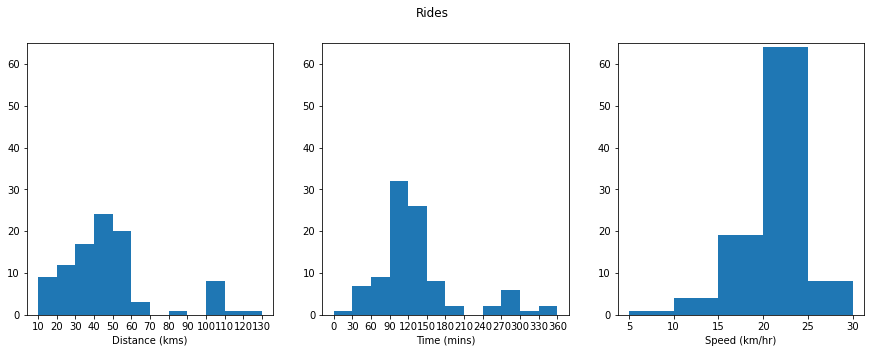

In [18]:
fig, axs = plt.subplots(1,3)

fig.suptitle("Runs")

axs[0].hist(runs['Distance'],bins=run_dist_bins,color='r')
axs[0].set_xlabel('Distance (kms)')
axs[0].set(xticks=run_dist_bins)
axs[0].set(ylim=run_ylimits)

axs[1].hist(runs['Minutes'],bins=run_time_bins,color='r')
axs[1].set_xlabel('Time (mins)')
axs[1].set(xticks=run_time_bins)
axs[1].set(ylim=run_ylimits)

axs[2].hist(runs['Speed'],bins=10,color='r')
axs[2].set_xlabel('Speed (km/hr)')
#axs[2].set(xticks=run_pace_bins)
axs[2].set(ylim=run_ylimits)

plt.gcf().set_size_inches(15,5)

fig, axs2 = plt.subplots(1,3)
fig.suptitle("Rides")

axs2[0].hist(rides['Distance'],bins=ride_dist_bins)
axs2[0].set_xlabel('Distance (kms)')
axs2[0].set(xticks=ride_dist_bins)
axs2[0].set(ylim=ride_ylimits)

axs2[1].hist(rides['Minutes'],bins=ride_time_bins)
axs2[1].set_xlabel('Time (mins)')
axs2[1].set(xticks=ride_time_bins)
axs2[1].set(ylim=ride_ylimits)

axs2[2].hist(rides['Speed'],bins=ride_speed_bins)
axs2[2].set_xlabel('Speed (km/hr)')
axs2[2].set(xticks=ride_speed_bins)
axs2[2].set(ylim=ride_ylimits)

plt.gcf().set_size_inches(15,5)

# Calendar Time

Using the [Calmap](https://pythonhosted.org/calmap/) package to plot some heatmap calendars of the Strava data.

''

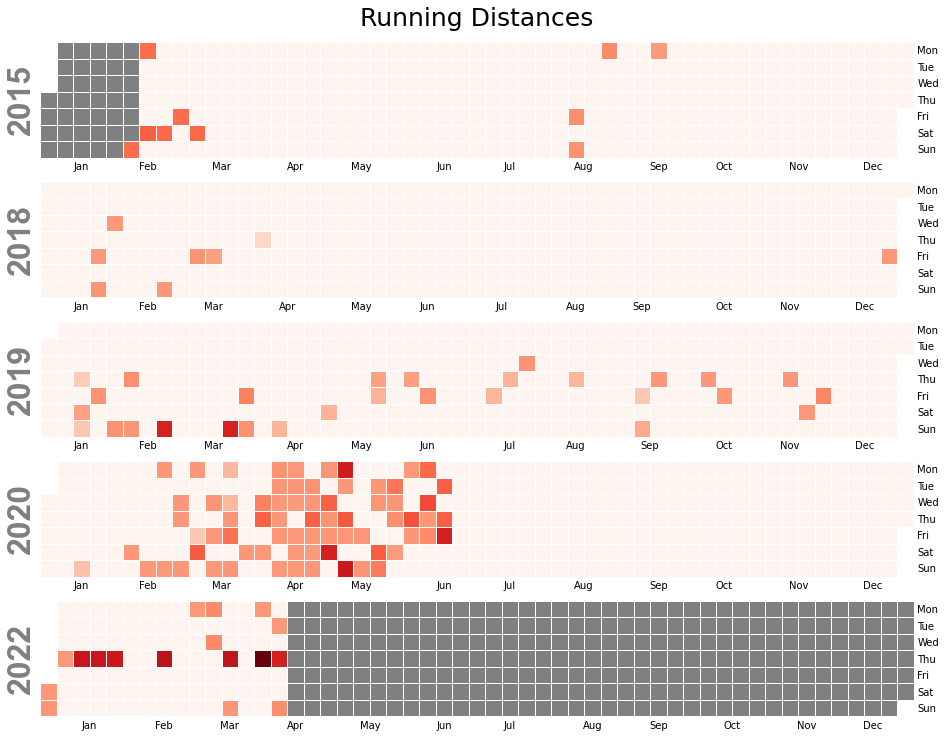

In [19]:
#import calplot

import calmap

# SHOULD I INDEX THE WHOLE DATAFRAMES ??? and use df[''] ???

runs_distance = pd.Series(data=runs['Distance'].values, index=runs['Activity Date'])
rides_distance = pd.Series(data=rides['Distance'].values, index=rides['Activity Date'])

fig, ax = calmap.calendarplot(runs_distance,cmap = 'Reds',fillcolor = 'grey',fig_kws = dict(figsize  =(20,10)))
fig.suptitle('Running Distances' , fontsize=25, y = 1.02)
;

''

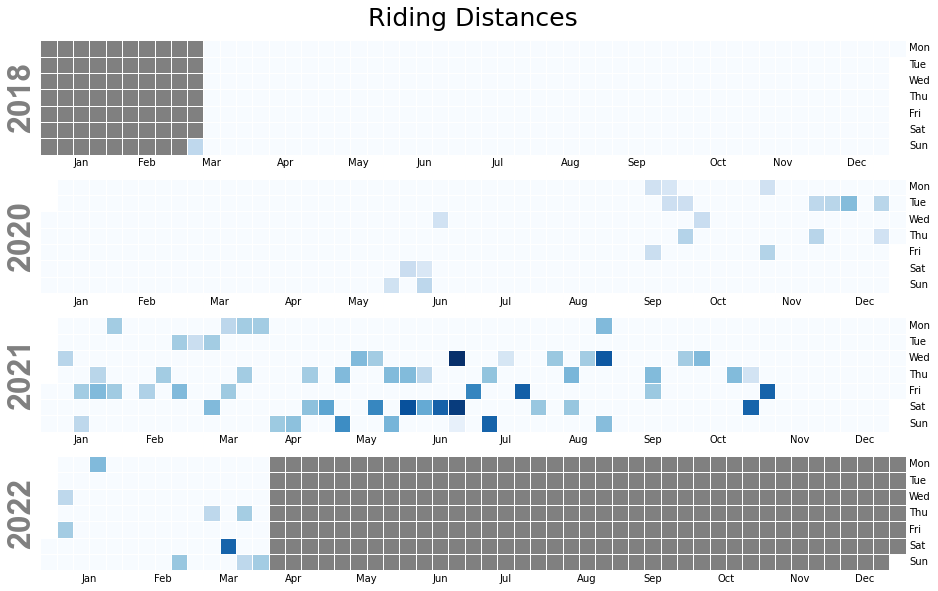

In [20]:
fig, ax2 = calmap.calendarplot(rides_distance,cmap='Blues',
                               fillcolor='grey',fig_kws=dict(figsize=(17,8)))
fig.suptitle('Riding Distances' , fontsize=25, y = 1.02)

;

In [21]:
#calmap.calendarplot(runs_distance, monthticks=3, daylabels='MTWTFSS',
#                    dayticks=[0, 2, 4, 6], cmap='YlGn',
#                    fillcolor='grey', linewidth=0,
#                    fig_kws=dict(figsize=(8, 4)))
#plt.gcf().set_size_inches(25,20)

In [22]:
runs_dates = pd.to_datetime(runs['Activity Date'])
runs_pace = pd.Series(data = runs['Speed'].values, index = runs_dates)

#calmap.calendarplot(runs_pace)
#plt.gcf().set_size_inches(25,20)
#calmap.yearplot(runs_pace, year=2020)
#plt.gcf().set_size_inches(25,20)

In [23]:
rides_dates = pd.to_datetime(rides['Activity Date'])
rides_speed = pd.Series(data = rides['Speed'].values, index = rides_dates)

#calmap.calendarplot(runs_pace)
#plt.gcf().set_size_inches(25,20)
#calmap.yearplot(rides_speed, year=2021)
#plt.gcf().set_size_inches(25,20)
print(max(rides_speed))
print(rides_speed.idxmax())

#why is the darkest square on a Sat when the greatest value is on a Wednesday (2021-05-19)
#print(rides_speed)

26.62
2021-05-19 18:13:07


# Resources

These are the blogs and and videos I used for inspiration and tips.

- [strava_py GitHub package](https://github.com/marcusvolz/strava_py) on processing and visualisation.
- ['Towards Data Science' Medium blog](https://towardsdatascience.com/using-the-strava-api-and-pandas-to-explore-your-activity-data-d94901d9bfde) on Strava API and visualisation.
- [Detailed Medium blog ](https://medium.com/analytics-vidhya/accessing-user-data-via-the-strava-api-using-stravalib-d5bee7fdde17) on Strava API using stravalib and visualisation.
- ['knanne' blog](https://knanne.github.io/notebooks/visualize_strava_data_in_python.html) on visualisation.
- [Youtube video](https://www.youtube.com/watch?v=sgscChKfGyg&t=7s) on Strava API.
- [Calmap](https://pythonhosted.org/calmap/) visualisation package.
